In [1]:
import numpy as np
import tensorflow
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import cv2
from matplotlib.pyplot import figure

(a)

In [2]:
(x_train, y_train), (x_val, y_val) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
# select samples with label 0 and 1
train_idx = y_train<=1
val_idx = y_val<=1
x_train = x_train[train_idx]
x_val = x_val[val_idx]
y_train = y_train[train_idx]
y_val = y_val[val_idx]

In [4]:
# subsample
x_train = [cv2.resize(x_train[i], (14, 14)) for i in range(len(x_train))]
x_val = [cv2.resize(x_val[i], (14, 14)) for i in range(len(x_val))]

(b)

In [5]:
# preparing data
x_train = np.array([x.flatten() for x in x_train])
x_val = np.array([x.flatten() for x in x_val])
y_train = np.array([1 if y == 0 else -1 for y in y_train])
y_val = np.array([1 if y == 0 else -1 for y in y_val])

In [6]:
# add one dimension
add_one_train = np.ones(x_train.shape[0]).reshape(-1,1)
add_one_val = np.ones(x_val.shape[0]).reshape(-1,1)
x_train = np.append(x_train, add_one_train, 1)
x_val = np.append(x_val, add_one_val, 1)

In [7]:
y_train.resize(y_train.shape[0], 1)
y_val.resize(y_val.shape[0], 1)

In [8]:
# normalize
x_train = np.nan_to_num(np.array(x_train)/np.sum(x_train,axis=0)) 
x_val = np.nan_to_num(np.array(x_val)/np.sum(x_val,axis=0)) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
def grad_w(w, x, y, lamb):
  """
  Params:
  w: weight matrix - image_dim x 1 array
  w0: bias term - 1 x 1 constant
  x: data - input_dim x image_dim array
  y: label - input_dim x 1 array
  lambda: regularization param

  Return: gradient of loss wrt weight w - image_dim x input_dim
  """
  n = np.shape(x)[0]
  temp = np.exp(-y*(np.matmul(x,w)))
  grad = -(1/n)*(np.sum(np.matmul(x.T, y*temp)/((temp+1).T),axis=1)).reshape(-1,1)+lamb*w
  return grad


In [10]:
def grad_descent(x, y, lamb, lr, n_iter, w_init):
  """
  Params:
  x: training data
  y: training label
  w0: bias 
  lamb: regularization param
  lr: learning rate
  n_iter: number of iterations
  w_init: initalization of weights

  Return:
  all weights - n_iter * image_dim
  """
  d = np.shape(x)[1]
  t = 0
  weights = []
  w = w_init
  weights.append(w)
  while t <= n_iter:
    w = w - lr*grad_w(w, x, y, lamb)
    t += 1
    weights.append(w)
  return np.array(weights)


In [11]:
def loss(w, x, y, lamb):
  """
  Params: 
  w: weight matrix - image_dim x 1 array
  x: data - input_dim x image_dim array
  y: label - input_dim x 1 array
  lambda: regularization param

  Return: loss
  """
  l = np.sum(np.log(1+np.exp(-y*np.matmul(x,w))))/np.shape(x)[0] + (lamb/2)*(np.linalg.norm(w)**2)
  return l

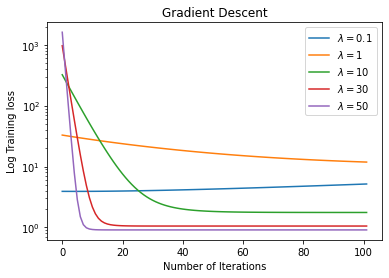

<Figure size 432x288 with 0 Axes>

In [12]:
lambdas = [0.1, 1, 10, 30, 50]
n_iters = 100
lr = 0.01
n = np.shape(x_train)[0]
d = np.shape(x_train)[1]
w_init = np.random.rand(d,1)
plotx = np.array(range(n_iters+2))
# list of lists
losses = []
loss_comparison = []
for lamb in lambdas:
  w_all = grad_descent(x_train, y_train, lamb, lr, n_iters, w_init)
  cur_loss = [loss(w, x_train, y_train, lamb) for w in w_all]
  losses.append(cur_loss)
  loss_comparison.append(cur_loss[-1])
  plt.semilogy(plotx, cur_loss, label= '$\lambda = $'+str(lamb))
plt.legend()
plt.ylabel('Log Training loss')
plt.xlabel('Number of Iterations')
plt.title('Gradient Descent')
plt.show()
plt.savefig("1b.pdf")


In [13]:
# pick the one with the best validation error
idx = loss_comparison.index(min(loss_comparison))
best_lamb = lambdas[idx]
best_loss = losses[idx]
print("The best lambda is {}".format(best_lamb))
# compute slopes
fit_params = np.polyfit(plotx[:2], np.log(best_loss[:2]),1)
slope = fit_params[0]
k = -1/slope
print("The slope is {}".format(slope))
print("k is {}".format(k))

The best lambda is 50
The slope is -1.3819992790989226
k is 0.7235893788975128


(d)

In [14]:
def nest_descent(x, y, rho, lamb, lr, n_iter, w_init):
  """
  rho: momentum parameter
  return: weights - num_iter * image_dim
  """
  # number of iterations
  t = 0
  d = x.shape[1]
  w = w_init
  w_next = w_init
  u = w_init
  u_all = []
  u_all.append(u)
  while t <= n_iter:
    w_next = u - lr*grad_w(u, x, y, lamb)
    u = (1+rho)*w_next-rho*w
    w = w_next
    u_all.append(u)
    t += 1
  return np.array(u_all)


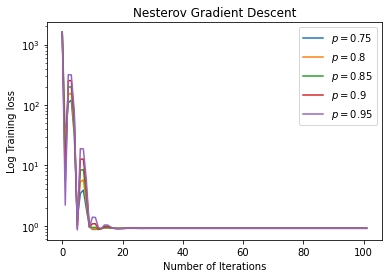

<Figure size 432x288 with 0 Axes>

In [22]:
rhos = [0.75, 0.8, 0.85, 0.9, 0.95]
lr = 0.01
num_iters = 100
# examine lambda
#best_lamb = 10
w_init = np.random.rand(d,1)
plotx = np.array(range(n_iters+2))
all_losses = []
all_weights = []
loss_comparison = []
for rho in rhos:
  cur_weights = nest_descent(x_train, y_train, rho, best_lamb, lr, num_iters, w_init)
  cur_loss = [loss(w, x_train, y_train, best_lamb) for w in cur_weights]
  loss_comparison.append(cur_loss[-1])
  all_weights.append(cur_weights)
  all_losses.append(cur_loss)
  plt.semilogy(plotx, cur_loss, label= '$p = $'+str(rho))
plt.legend()
plt.ylabel('Log Training loss')
plt.xlabel('Number of Iterations')
plt.title('Nesterov Gradient Descent')
plt.show()
plt.savefig("1d.pdf")


In [16]:
# find the best rho
idx = loss_comparison.index(min(loss_comparison))
best_rho = rhos[idx]
best_loss = all_losses[idx]
print("The best momentum is {}".format(best_rho))
# compute slopes
fit_params = np.polyfit(plotx[:2], np.log(best_loss[:2]),1)
slope2 = fit_params[0]
k2 = 1/slope2**2
print("The slope is {}".format(slope2))
print("k is {}".format(k2))

The best momentum is 0.9
The slope is -5.686130160603678
k is 0.030929037582099504


In [17]:
# k = L/m
m = -slope
L = k2*m
print("The best L is: ", L)

The best L is:  0.042743907641685


(e)

In [18]:
def sgd_minibatch(x, y, batch_size, lamb, lr, n_iter, w_init):
  """
  return weights : n_iter x image_dim
  """
  n = x.shape[0]
  d = x.shape[1]
  weights = []
  weights.append(w_init)
  t = 0
  w = w_init
  while t<= n_iter:
    sample_idx = np.random.randint(n, size=batch_size)
    sample_x = x[sample_idx]
    sample_y = y[sample_idx]
    w = w - lr*grad_w(w, sample_x, sample_y, lamb)
    weights.append(w)
    t += 1
  return np.array(weights)

In [19]:
def sgd_minibatch_nest(x, y, batch_size, rho, lamb, lr, n_iter, w_init):
  n = x.shape[0]
  d = x.shape[1]
  u_all = []
  t = 0
  w = w_init
  u = w_init
  u_all.append(u)
  while t <= n_iter:
    sample_idx = np.random.randint(n, size=batch_size)
    sample_x = x[sample_idx]
    sample_y = y[sample_idx]
    w_next = u - lr*grad_w(u, sample_x, sample_y, lamb)
    u = (1+rho)*w_next-rho*w
    w = w_next
    u_all.append(u)
    t += 1
  return np.array(u_all)

In [25]:
# using best lambda and best rho
batch = 128
lr = 0.01
n_iter = 100
w_init = np.random.rand(d,1)
w_gd = grad_descent(x_train, y_train, best_lamb, lr, n_iter, w_init)
w_nest_gd = nest_descent(x_train, y_train, best_rho, best_lamb, lr, n_iter, w_init)
w_sgd = sgd_minibatch(x_train, y_train, batch, best_lamb, lr, n_iter, w_init)
w_nest_sgd = sgd_minibatch_nest(x_train, y_train, batch, best_rho, best_lamb, lr, n_iter, w_init)

loss_gd = [loss(w, x_train, y_train, best_lamb) for w in w_gd]
loss_nest_gd = [loss(w, x_train, y_train, best_lamb) for w in w_nest_gd]
loss_sgd = [loss(w, x_train, y_train, best_lamb) for w in w_sgd]
loss_nest_sgd = [loss(w, x_train, y_train, best_lamb) for w in w_nest_sgd]

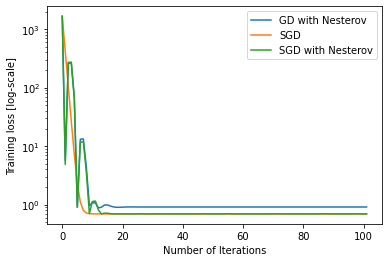

<Figure size 432x288 with 0 Axes>

In [26]:
plotx = np.array(range(len(w_gd)))
plt.semilogy(plotx, loss_nest_gd)
plt.semilogy(plotx, loss_sgd)
plt.semilogy(plotx, loss_nest_sgd)
plt.legend(('GD with Nesterov','SGD','SGD with Nesterov') )
plt.ylabel('Training loss [log-scale]')
plt.xlabel('Number of Iterations')
plt.show()
plt.savefig('1e.pdf')